# Low pass filter in FPGA: Verification script

A low pass filter, with cutoff frequency of 11025Hz was implemented in the FPGA using DSP slices. The following script shows a verification of its functionality by comparing its output with Low Pass filter implemented in Python.

In [1]:
# Upload overlay into FPGA.
from pynq import Overlay
from pynq import allocate

overlay = Overlay("/home/xilinx/pynq/overlays/LPF/low_pass_filter.bit")

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
import numpy as np

# Compute the coefficients of a low-pass windowed-sinc filter, stored as numpy array h.
# Configuration.
fS = 44100  # Sampling rate.
fL = 11025  # Cutoff frequency.
N = 35  # Filter length.
# Compute sinc filter.
h = np.sinc(2 * fL / fS * (np.arange(N) - (N - 1) / 2))
# Apply window.
h *= np.hamming(N)
# Normalize to get unity gain.
h /= np.sum(h)

In [3]:
# Create test signal with high frequency noise.
duration = 2  # Duration of the test signal in seconds
t = np.linspace(0, duration, int(fS * duration), endpoint=False)
clean_signal = (2000 * np.sin(2 * np.pi * 1 * t)).astype(int)  # A clean sine wave 1 Hz.
noise_signal_1 = (200  * np.sin(2 * np.pi * 22000 * t)).astype(int)  # High-frequency noise signal
test_signal = clean_signal + noise_signal_1  # Combined signal with noise
# Apply the low-pass filter.
filtered_signal = np.convolve(test_signal, h, mode='same')

In [4]:
# Pynq FPGA configuration:
dma = overlay.dma         # Define DMA (Direct memory access) object.
data_size = int(fS * duration)
# Allocate memory in DRAM.
input_buffer = allocate(shape=(data_size,), dtype=np.int32)
output_buffer = allocate(shape=(data_size,), dtype=np.int32)
# Move test signal array to DRAM storage.
input_buffer[:] = test_signal 
# Print input and output buffer for debugging.
print("DRAM INPUT BUFFER: ", end="")
print(input_buffer)
print("DRAM OUTPUT BUFFER: ", end="")
print(output_buffer)

DRAM INPUT BUFFER: [ 0  1 -2 ... -4  2 -1]
DRAM OUTPUT BUFFER: [0 0 0 ... 0 0 0]


In [5]:
# Send input buffer into FPGA fabric through DMA. 
dma.sendchannel.transfer(input_buffer)

In [6]:
# Recieve data after being processed by FPGA. This process will finish when FIR module raises TLAST flag 
# on AXI4 Stream interface.
dma.recvchannel.transfer(output_buffer)
# Transaction finished and save data into numpy array.
print("FINISHED TRANSACTION.")
output_fromFPGA = 2*output_buffer[:]  # Multiplied by 2 to account for 1 LSB lost after output of FIR filter.

FINISHED TRANSACTION.


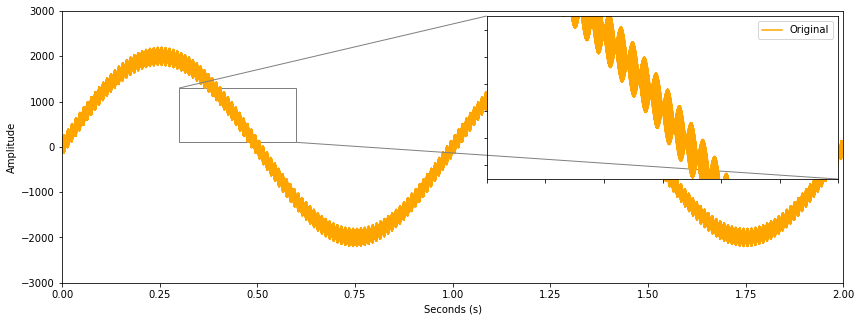

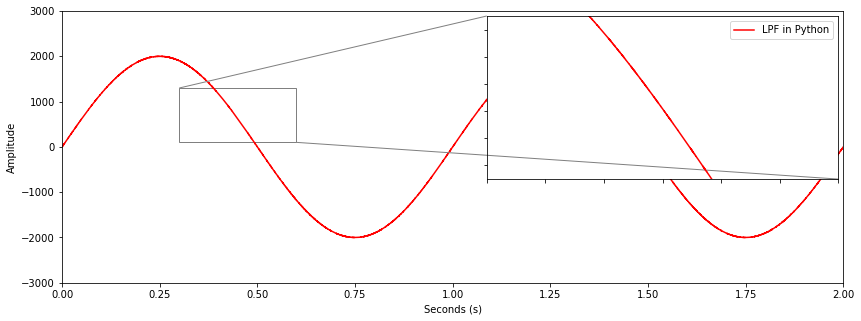

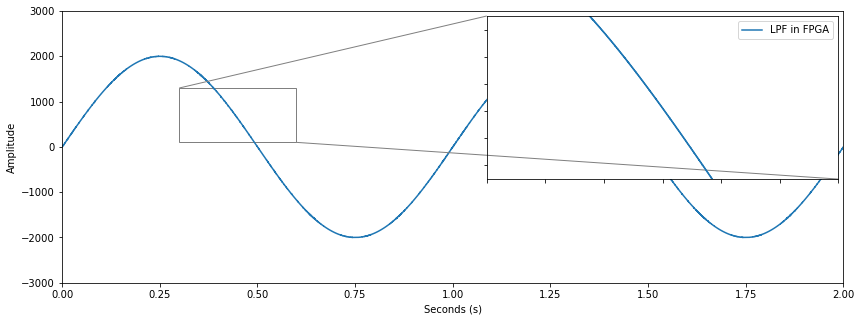

In [7]:
# Plots.

# Original
fig, ax = plt.subplots(figsize=(14,5))          # Plotting graph
ax.plot(t, test_signal, label='Original', color="orange")
# Create a zoomed inset axes
axins = zoomed_inset_axes(ax, zoom=3, loc='upper right')
# Plot the zoomed-in portion
axins.plot(t, test_signal, label='Original', color="orange")
axins.set_xticklabels('')
axins.set_yticklabels('')
axins.set_xlim(0.30, 0.6)
axins.set_ylim(100, 1300)
# Mark the zoomed-in region
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
# Set labels and legends
ax.set_xlabel('Seconds (s)')
ax.set_ylabel('Amplitude')
ax.legend()
ax.set_xlim([0, 2])
ax.set_ylim([-3000, 3000])
axins.legend()
# Show the plot
plt.show()

# Filtered in software
fig, ax = plt.subplots(figsize=(14,5))          # Plotting graph
ax.plot(t, filtered_signal, label='LPF in Python', color="red")
# Create a zoomed inset axes
axins = zoomed_inset_axes(ax, zoom=3, loc='upper right')
# Plot the zoomed-in portion
axins.plot(t, filtered_signal, label='LPF in Python', color="red")
axins.set_xticklabels('')
axins.set_yticklabels('')
axins.set_xlim(0.30, 0.6)
axins.set_ylim(100, 1300)
# Mark the zoomed-in region
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
# Set labels and legends
ax.set_xlabel('Seconds (s)')
ax.set_ylabel('Amplitude')
ax.legend()
ax.set_xlim([0, 2])
ax.set_ylim([-3000, 3000])
axins.legend()
# Show the plot
plt.show()

# Filtered in FPGA
fig, ax = plt.subplots(figsize=(14,5))          # Plotting graph
ax.plot(t, output_fromFPGA, label='LPF in FPGA')
# Create a zoomed inset axes
axins = zoomed_inset_axes(ax, zoom=3, loc='upper right')
# Plot the zoomed-in portion
axins.plot(t, output_fromFPGA, label='LPF in FPGA')
axins.set_xticklabels('')
axins.set_yticklabels('')
axins.set_xlim(0.30, 0.6)
axins.set_ylim(100, 1300)
# Mark the zoomed-in region
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
# Set labels and legends
ax.set_xlabel('Seconds (s)')
ax.set_ylabel('Amplitude')
ax.legend()
ax.set_xlim([0, 2])
ax.set_ylim([-3000, 3000])
axins.legend()
# Show the plot
plt.show()

In [ ]:
del input_buffer, output_buffer